In [1]:
from h2_gym.algs import KalmanFilter
from pandas import DataFrame

[NOTE] Less than 12 month data left. Generating synthetic data


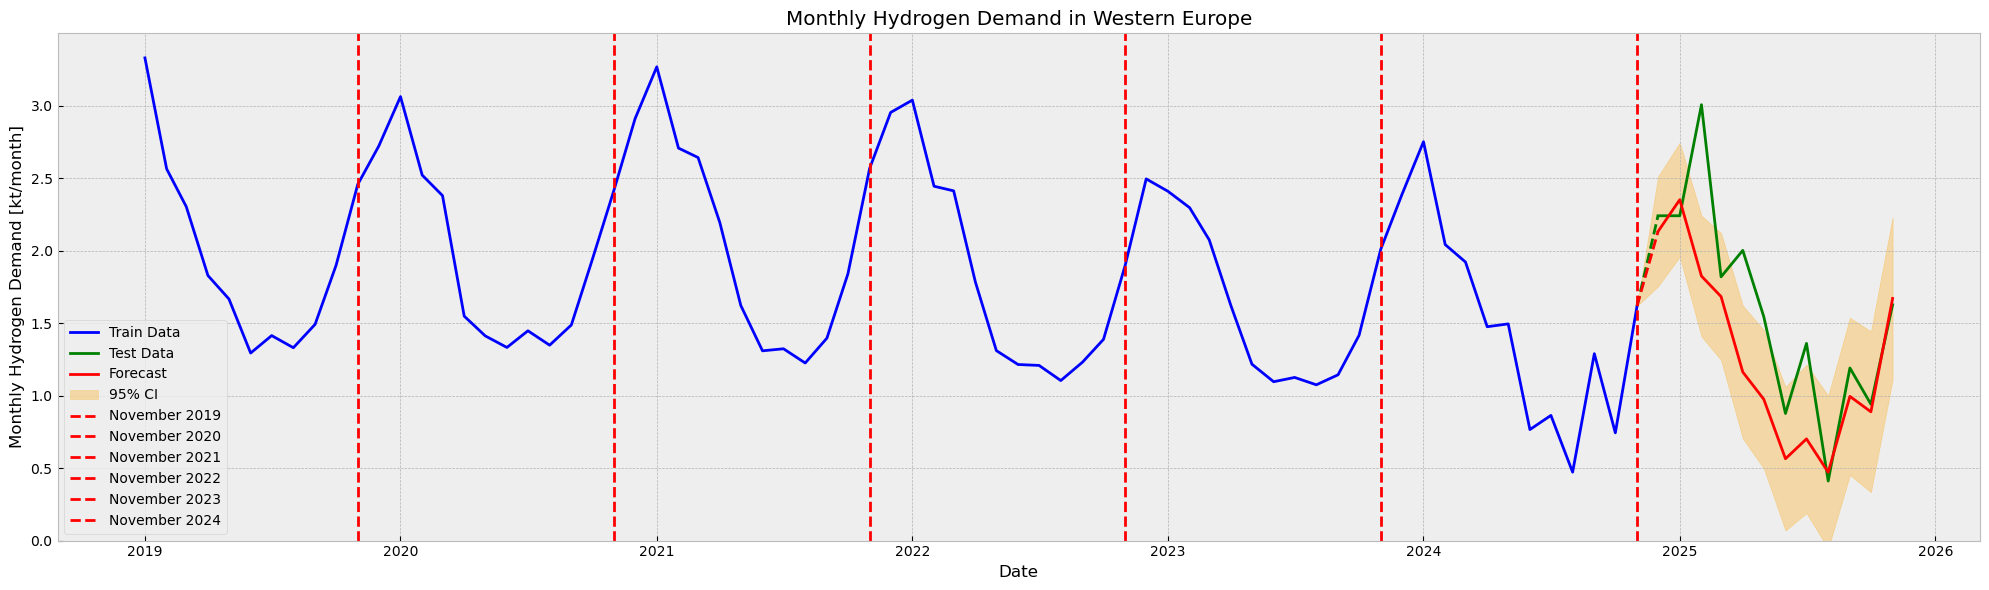

In [5]:
filter = KalmanFilter('EU','monthly','total')
filter.scale_dataset(24.3)
filter.fit_train()
for i in range(1, 48+12):
    filter.update()
plt = filter.plot()
plt.ylabel('Monthly Hydrogen Demand [kt/month]')
plt.title('Monthly Hydrogen Demand in Western Europe')
import pandas as pd

for year in [2019, 2020, 2021,2022,2023,2024]:
    plt.axvline(x=pd.Timestamp(f'Nov-{year}'), color='red', linestyle='--', label=f'November {year}')
plt.legend()
plt.show()

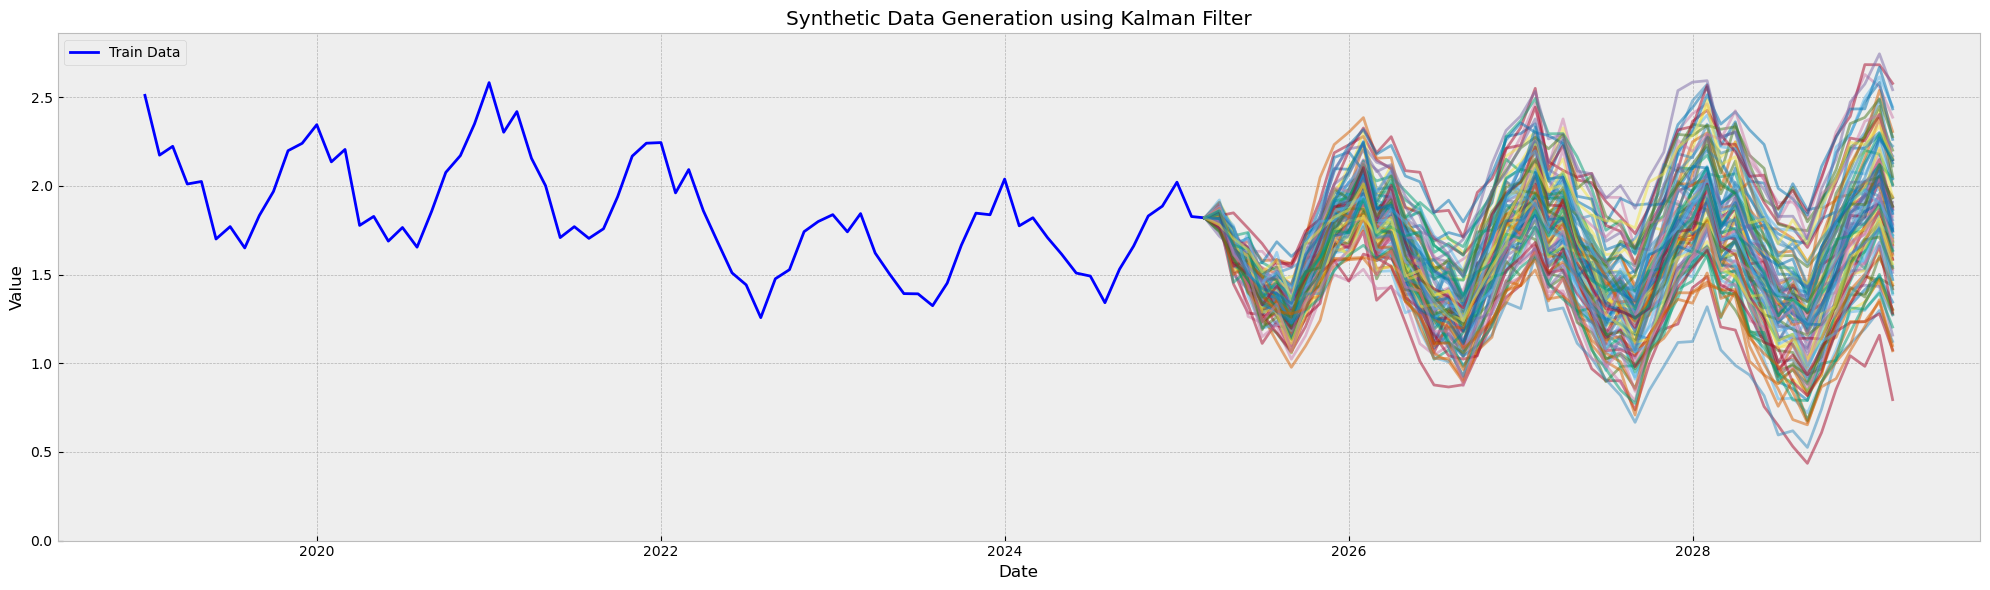

In [12]:
sims = filter.gen_multi_synth(100,48)
_plt = filter.plot_synth(sims)